"Grupo 2"

- Aaban Vasconcelos Zyzzyag (avz@cesar.school)
- Celina Gondim (acgs2@cesar.school)
- Mirella Farias (mcf4@cesar.school)

 https://www.kaggle.com/api/v1/datasets/download/muratkokludataset/date-fruit-datasets

# Projeto de Machine Learning - Algoritmo para classificação

## Importação das bibliotecas

In [111]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, random_split, DataLoader

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

### Seed para garantir a reprodutibilidade

In [112]:
torch.manual_seed(1111)
device = torch.device("cpu")

## Dataset

### Download e unzip do dataset

In [113]:
#!/bin/bash
!curl -L -o /content/date-fruit-datasets.zip\
  https://www.kaggle.com/api/v1/datasets/download/muratkokludataset/date-fruit-datasets

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  408k  100  408k    0     0   585k      0 --:--:-- --:--:-- --:--:--  585k


In [114]:
!unzip -o  /content/date-fruit-datasets.zip -d /content/date-fruit-datasets

Archive:  /content/date-fruit-datasets.zip
  inflating: /content/date-fruit-datasets/Date_Fruit_Datasets/Date_Fruit_Datasets.arff  
  inflating: /content/date-fruit-datasets/Date_Fruit_Datasets/Date_Fruit_Datasets.xlsx  
  inflating: /content/date-fruit-datasets/Date_Fruit_Datasets/Date_Fruit_Datasets_Citation_Request.txt  


In [115]:
Date_Fruit_Datasets = "/content/date-fruit-datasets/Date_Fruit_Datasets/Date_Fruit_Datasets.xlsx"

## Análise e tratativa dos dados

In [116]:
df = pd.read_excel(Date_Fruit_Datasets)
df.head()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,EntropyRG,EntropyRB,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB,Class
0,422163,2378.908,837.8484,645.6693,0.6373,733.1539,0.9947,424428,0.7831,1.2976,...,3.2370,2.9574,4.2287,-59191263232,-50714214400,-39922372608,58.7255,54.9554,47.8400,BERHI
1,338136,2085.144,723.8198,595.2073,0.5690,656.1464,0.9974,339014,0.7795,1.2161,...,2.6228,2.6350,3.1704,-34233065472,-37462601728,-31477794816,50.0259,52.8168,47.8315,BERHI
2,526843,2647.394,940.7379,715.3638,0.6494,819.0222,0.9962,528876,0.7657,1.3150,...,3.7516,3.8611,4.7192,-93948354560,-74738221056,-60311207936,65.4772,59.2860,51.9378,BERHI
3,416063,2351.210,827.9804,645.2988,0.6266,727.8378,0.9948,418255,0.7759,1.2831,...,5.0401,8.6136,8.2618,-32074307584,-32060925952,-29575010304,43.3900,44.1259,41.1882,BERHI
4,347562,2160.354,763.9877,582.8359,0.6465,665.2291,0.9908,350797,0.7569,1.3108,...,2.7016,2.9761,4.4146,-39980974080,-35980042240,-25593278464,52.7743,50.9080,42.6666,BERHI


In [117]:
(df.nunique()/len(df)).sort_values(ascending=True)

,0
Class,0.007795
SHAPEFACTOR_2,0.031180
SHAPEFACTOR_1,0.040089
SHAPEFACTOR_4,0.270601
SOLIDITY,0.381960
EXTENT,0.788419
COMPACTNESS,0.799555
ROUNDNESS,0.827394
ECCENTRICITY,0.873051
SHAPEFACTOR_3,0.877506


In [118]:
df['Class'].unique()

array(['BERHI', 'DEGLET', 'DOKOL', 'IRAQI', 'ROTANA', 'SAFAVI', 'SOGAY'],
      dtype=object)

In [119]:
df.describe()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,SkewRB,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,EntropyRG,EntropyRB,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB
count,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,...,898.000000,898.000000,898.000000,898.000000,8.980000e+02,8.980000e+02,8.980000e+02,898.000000,898.000000,898.000000
mean,298295.207127,2057.660953,750.811994,495.872785,0.737468,604.577938,0.981840,303845.592428,0.736267,2.131102,...,0.250518,4.247845,5.110894,3.780928,-3.185021e+10,-2.901860e+10,-2.771876e+10,50.082888,48.805681,48.098393
std,107245.205337,410.012459,144.059326,114.268917,0.088727,119.593888,0.018157,108815.656947,0.053745,17.820778,...,0.632918,2.892357,3.745463,2.049831,2.037241e+10,1.712952e+10,1.484137e+10,16.063125,14.125911,10.813862
min,1987.000000,911.828000,336.722700,2.283200,0.344800,50.298400,0.836600,2257.000000,0.512300,1.065300,...,-1.029100,1.708200,1.607600,1.767200,-1.091224e+11,-9.261697e+10,-8.747177e+10,15.191100,20.524700,22.130000
25%,206948.000000,1726.091500,641.068650,404.684375,0.685625,513.317075,0.978825,210022.750000,0.705875,1.373725,...,-0.196950,2.536625,2.508850,2.577275,-4.429444e+10,-3.894638e+10,-3.564534e+10,38.224425,38.654525,39.250725
50%,319833.000000,2196.345450,791.363400,495.054850,0.754700,638.140950,0.987300,327207.000000,0.746950,1.524150,...,0.135550,3.069800,3.127800,3.080700,-2.826156e+10,-2.620990e+10,-2.392928e+10,53.841300,50.337800,49.614100
75%,382573.000000,2389.716575,858.633750,589.031700,0.802150,697.930525,0.991800,388804.000000,0.775850,1.674750,...,0.593950,4.449850,7.320400,4.283125,-1.460482e+10,-1.433105e+10,-1.660367e+10,63.063350,59.573600,56.666675
max,546063.000000,2811.997100,1222.723000,766.453600,1.000000,833.827900,0.997400,552598.000000,0.856200,535.525700,...,3.092300,26.171100,26.736700,32.249500,-1.627316e+08,-5.627727e+08,-4.370435e+08,79.828900,83.064900,74.104600


In [120]:
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

In [121]:
df['Class'].unique()

array([0, 1, 2, 3, 4, 5, 6])

### Normalizando

In [122]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df.drop('Class', axis=1))
y = df['Class'].values

In [123]:
X.shape

(898, 34)

In [124]:
y.shape

(898,)

### Convertendo para tensores


In [125]:
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(y, dtype=torch.long)

### Classe do dataset e Split

In [126]:
class FruitDataset(Dataset):
    def __init__(self, X, Y):
      super(FruitDataset, self).__init__()
      if len(X) != len(Y):
        raise ValueError("X e Y precisam ter o mesmo tamanho.")
      self.X = X
      self.Y = Y
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

### Split

In [127]:
dataset = FruitDataset(X_tensor, Y_tensor)
train_size = int(0.7 * len(dataset))
val_size   = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Treino: {len(train_data)} | Validação: {len(val_data)}")

Treino: 628 | Validação: 270


In [128]:
dataset

### DataLoaders

In [129]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(val_data,   batch_size=128, shuffle=False)
print(f"Dados de treinamento: {len(train_data)}")
print(f"Dados de validação: {len(val_data)}")
print(f"Dataloaders de treinamento: {len(train_loader)}")
print(f"Dataloaders de validação: {len(test_loader)}")

Dados de treinamento: 628
Dados de validação: 270
Dataloaders de treinamento: 10
Dataloaders de validação: 3


## Rede Neural

In [130]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(34, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 7)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.output(x)

model = Net().to(device)
print(model)

Net(
  (layer1): Linear(in_features=34, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=7, bias=True)
)


### Function de treino

In [131]:
def train(log_interval, model, device, train_loader, optimizer, epoch, criterion):
    model.train()
    total_loss = 0
    total_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * target.size(0)
        total_samples += target.size(0)

        if batch_idx % log_interval == 0:
            print(f"Train Epoch [{epoch}/{epochs}]  Loss: {loss.item():.4f}")

    return total_loss / total_samples

### Function de teste

In [132]:
def test(model, device, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item() * target.size(0)
            total_samples += target.size(0)

            _, preds = output.max(1)
            correct += preds.eq(target).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = 100. * correct / total_samples
    return accuracy, avg_loss

### Config de otimization

In [133]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

### Loop de treinamento com coleta de metricas

In [134]:
epochs = 300
train_losses = []
test_losses = []
test_accuracies = []

In [135]:
# Avaliação antes de treinar
acc0, loss0 = test(model, device, test_loader, criterion)
print(f"Antes do treino → Accuracy: {acc0:.2f}% | Loss: {loss0:.4f}\n")

for epoch in range(1, epochs+1):

    tloss = train(10, model, device, train_loader, optimizer, epoch, criterion)
    acc,  tloss_val = test(model, device, test_loader, criterion)

    train_losses.append(tloss)
    test_losses.append(tloss_val)
    test_accuracies.append(acc)

    scheduler.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch} → Val Acc: {acc:.2f}% | Val Loss: {tloss_val:.4f}\n")

Antes do treino → Accuracy: 8.89% | Loss: 1.9571

Train Epoch [1/300]  Loss: 1.9541
Train Epoch [2/300]  Loss: 1.9349
Train Epoch [3/300]  Loss: 1.8773
Train Epoch [4/300]  Loss: 1.8313
Train Epoch [5/300]  Loss: 1.8169
Train Epoch [6/300]  Loss: 1.7754
Train Epoch [7/300]  Loss: 1.7094
Train Epoch [8/300]  Loss: 1.3206
Train Epoch [9/300]  Loss: 1.3079
Train Epoch [10/300]  Loss: 1.3470
Train Epoch [11/300]  Loss: 1.4044
Train Epoch [12/300]  Loss: 1.1657
Train Epoch [13/300]  Loss: 1.1464
Train Epoch [14/300]  Loss: 1.1111
Train Epoch [15/300]  Loss: 1.0032
Train Epoch [16/300]  Loss: 1.0064
Train Epoch [17/300]  Loss: 0.8369
Train Epoch [18/300]  Loss: 0.7550
Train Epoch [19/300]  Loss: 0.7464
Train Epoch [20/300]  Loss: 0.6585
Epoch 20 → Val Acc: 80.00% | Val Loss: 0.5974

Train Epoch [21/300]  Loss: 0.7471
Train Epoch [22/300]  Loss: 0.6422
Train Epoch [23/300]  Loss: 0.6088
Train Epoch [24/300]  Loss: 0.6528
Train Epoch [25/300]  Loss: 0.4251
Train Epoch [26/300]  Loss: 0.5789
Tr

### Plots das metricas

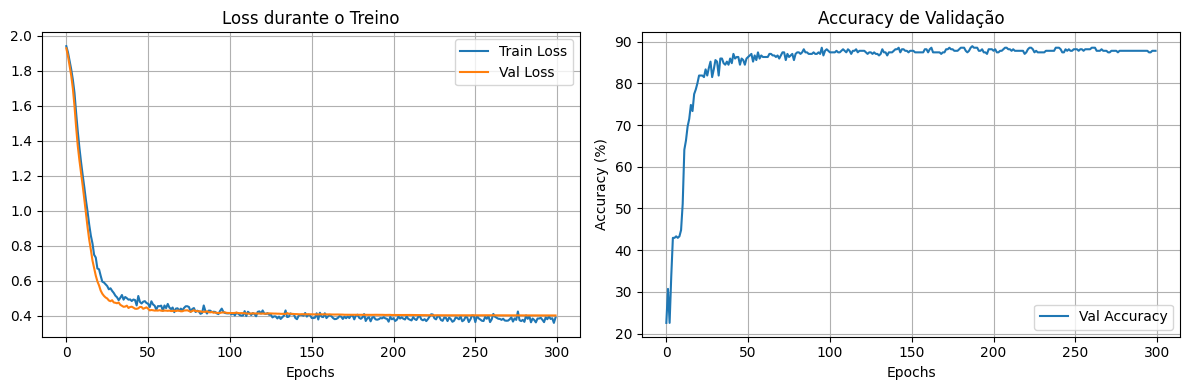

In [136]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses,  label='Val Loss')
plt.title("Loss durante o Treino")
plt.xlabel("Epochs")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Val Accuracy')
plt.title("Accuracy de Validação")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Avaliação Final


Classification Report - Dados de teste:

              precision    recall  f1-score   support

       BERHI       0.89      0.44      0.59        18
      DEGLET       0.91      0.67      0.77        30
       DOKOL       0.90      0.97      0.93        59
       IRAQI       0.74      0.94      0.83        18
      ROTANA       0.87      0.95      0.91        58
      SAFAVI       0.98      0.97      0.97        59
       SOGAY       0.72      0.82      0.77        28

    accuracy                           0.88       270
   macro avg       0.86      0.82      0.83       270
weighted avg       0.88      0.88      0.87       270



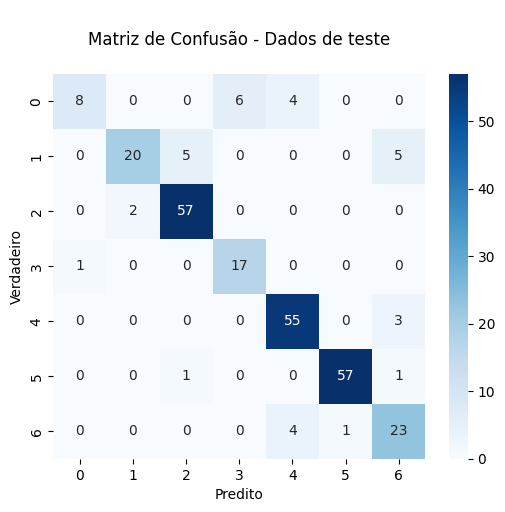


Classification Report - Dados de treino:

              precision    recall  f1-score   support

       BERHI       0.64      0.53      0.58        47
      DEGLET       0.77      0.60      0.68        68
       DOKOL       0.92      0.97      0.94       145
       IRAQI       0.77      0.80      0.78        54
      ROTANA       0.92      0.95      0.94       108
      SAFAVI       0.98      0.99      0.99       140
       SOGAY       0.74      0.82      0.78        66

    accuracy                           0.87       628
   macro avg       0.82      0.81      0.81       628
weighted avg       0.86      0.87      0.86       628



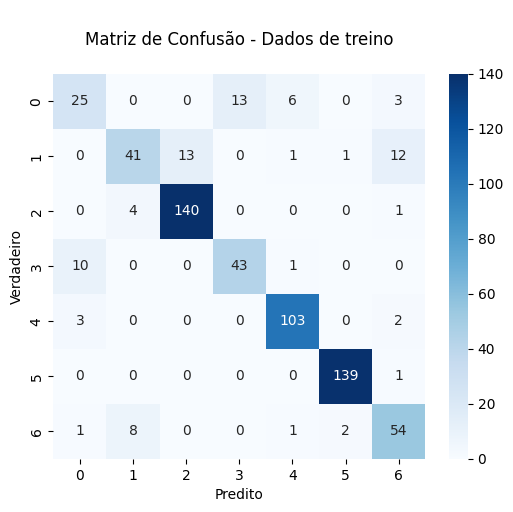

In [139]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, preds = output.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

print("\nClassification Report - Dados de teste:\n")
print(classification_report(all_targets, all_preds, target_names=le.classes_))

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(all_targets, all_preds), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("\nMatriz de Confusão - Dados de teste\n")
plt.show()

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, preds = output.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

print("\nClassification Report - Dados de treino:\n")
print(classification_report(all_targets, all_preds, target_names=le.classes_))

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(all_targets, all_preds), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("\nMatriz de Confusão - Dados de treino\n")
plt.show()

# Aprendizado

**O trabalho foi desenvolvido em 4 etapas:**



*   Na **primeira**, importamos o dataset, fizemos a análise e tratativa dos dados passando pela normalização, criaçãos dos tensores, definição das bases de treino e teste e criação dos dataloaders. Pausamos na definição da Rede Neural, pois estávamos seguindo o Notebook 4.6-MNIST_neuralnet.ipynb (problema de regressão), conforme sugerido, até consideramos as adaptações necessárias do para criterion, optimizer e accuracy em nosso **problema de CLASSIFICAÇÃO** onde o output são 7 tipos de tâmaras.

* Então, na **segunda** etapa criamos a rede neural com o criterion definido por `nn.CrossEntropyLoss()` , o opmizer como `optimizer = optim.SGD(model.parameters(), lr=0.001)` e o cálculo da acurácia ao invés do MSE. Obtivemos um PÉSSIMO resultado com train loss e val loss diminuindo lentamente, mas permanecendo altos (~1.90) e acurácia abaixo de 22% estagnada antes da 30ª época. Um caso claro de **UNDERFITTING**.

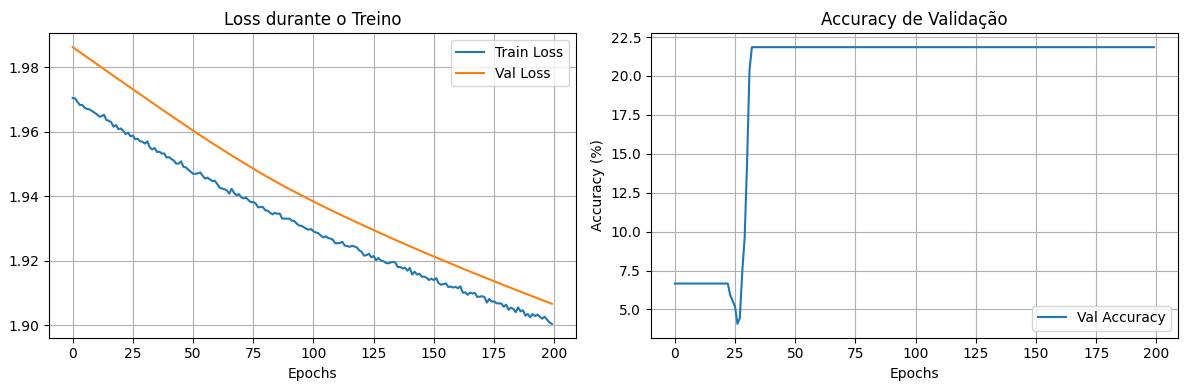

* No **terceiro** momento, trocamos o opmizer para `optimizer = optim.Adam(model.parameters(), lr=0.001)` e aumentamos o número de épocas de 200 para 500. Desta forma, a acurácia ficou acima de 90%, entretanto tivemos um caso claro de **OVERFITTING**: o train loss continua caindo enquanto o val loss estabiliza e começa a subir lentamente a partir da época 150–200, indicando que o modelo continua aprendendo os dados de treino, mas piora na validação.

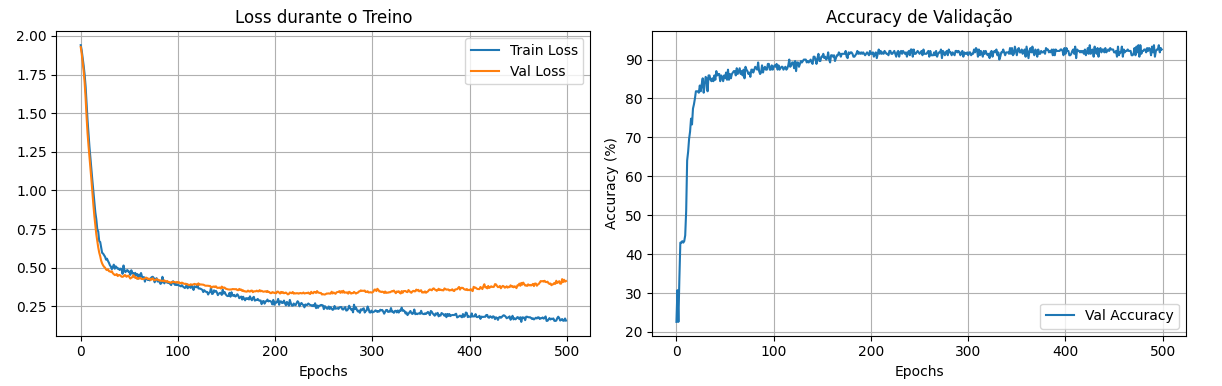

* No **quarto** momento, incluimos o scheduler para reduzir de forma escalonada o learning rate do otimizador `scheduler = StepLR(optimizer, step_size=50, gamma=0.5)`. Desta forma, **o resultado final foi uma acurácia entre 88 - 89% com as curvas do Train Loss e Val Loss praticamente sobrepostas em 0.4 a partir da época 100–150 indicando uma boa generalização dos dados e do modelo**.

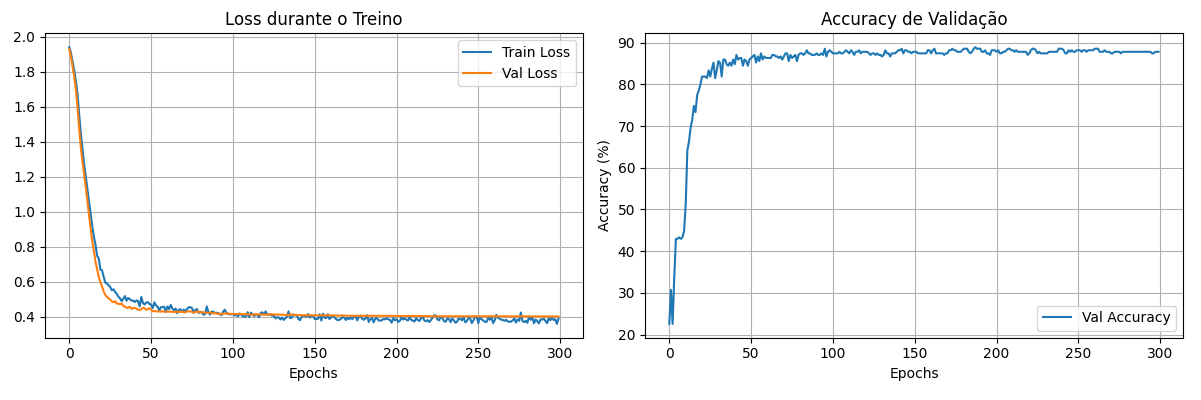
